## 1) Imports & load data 

In [4]:
# Cell 1 — imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Replace with your filename if different
CSV_PATH = Path("hospital dataset.csv")

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())
display(df.dtypes)
# show missingness summary
missing = df.isna().sum().sort_values(ascending=False)
display(missing.to_frame(name="missing_count").head(30))

Shape: (4960, 33)


,Age Group,Count of APR DRG Code,APR DRG Description,Count of APR MDC Code,APR MDC Description,APR Medical Surgical Description,APR Risk of Mortality,Count of APR Severity of Illness Code,APR Severity of Illness Description,Sum of Birth Weight,...,Patient Disposition,Payment Typology 1,Payment Typology 2,Payment Typology 3,Count of Permanent Facility Id,Race,Sum of Total Charges,Sum of Total Costs,Type of Admission,Zip Code - 3 digits
0,0 to 17,1,ABDOMINAL PAIN,1,DISEASES AND DISORDERS OF THE DIGESTIVE SYSTEM,Medical,Minor,1,Moderate,NaN,...,Home or Self Care,Medicaid,Medicaid,NaN,1.0,White,76624.58,11638.06,Emergency,117
1,0 to 17,1,ACUTE ANXIETY & DELIRIUM STATES,1,MENTAL DISEASES AND DISORDERS,Medical,Minor,1,Moderate,NaN,...,Home or Self Care,Medicaid,Medicaid,NaN,1.0,Other Race,10155.49,6749.34,Emergency,100
2,0 to 17,1,ACUTE BRONCHITIS AND RELATED SYMPTOMS,1,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,Medical,Minor,1,Major,NaN,...,Home or Self Care,Private Health Insurance,NaN,NaN,1.0,White,73197.65,33309.64,Emergency,100
3,0 to 17,1,ACUTE KIDNEY INJURY,1,DISEASES AND DISORDERS OF THE KIDNEY AND URINA...,Medical,Major,1,Major,NaN,...,Home or Self Care,Medicaid,Self-Pay,NaN,1.0,Other Race,59651.17,18065.91,Urgent,112
4,0 to 17,1,ADJUSTMENT DISORDERS & NEUROSES EXCEPT DEPRESS...,1,MENTAL DISEASES AND DISORDERS,Medical,Minor,1,Major,NaN,...,Home or Self Care,Medicaid,NaN,NaN,1.0,Black/African American,18200.00,12095.72,Emergency,112


Age Group                                 object
Count of APR DRG Code                      int64
APR DRG Description                       object
Count of APR MDC Code                      int64
APR MDC Description                       object
APR Medical Surgical Description          object
APR Risk of Mortality                     object
Count of APR Severity of Illness Code      int64
APR Severity of Illness Description       object
Sum of Birth Weight                      float64
CCSR Diagnosis Code                       object
CCSR Diagnosis Description                object
CCSR Procedure Code                       object
CCSR Procedure Description                object
Sum of Discharge Year                      int64
Emergency Department Indicator              bool
Ethnicity                                 object
Facility Name                             object
Gender                                    object
Hospital County                           object
Hospital Service Are

,missing_count
Sum of Birth Weight,4719
Payment Typology 3,4099
Payment Typology 2,2004
CCSR Procedure Description,1331
CCSR Procedure Code,1331
Zip Code - 3 digits,80
Count of Permanent Facility Id,17
Hospital County,17
Sum of Operating Certificate Number,17
Hospital Service Area,17


## 2) Quick EDA 

Selected target: Sum of Total Costs


count    4.960000e+03
mean     2.041225e+04
std      3.982346e+04
min      1.716900e+02
25%      5.967392e+03
50%      1.084812e+04
75%      2.109778e+04
max      1.192711e+06
Name: Sum of Total Costs, dtype: float64

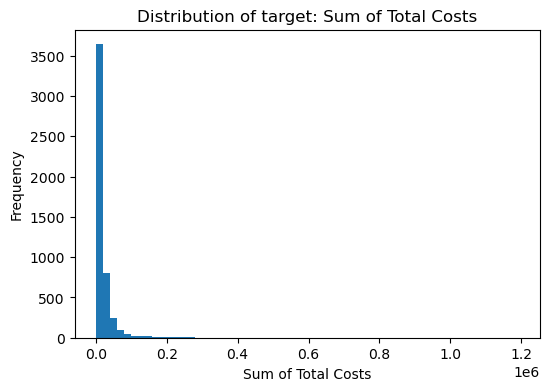

In [7]:
# Cell 2 — detect target (heuristic) and inspect
target_tokens = ["cost", "charge", "expense", "bill", "amount", "payment", "payout", "claim", "charges", "costs"]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
candidates = [c for c in df.columns if any(tok in c.lower() for tok in target_tokens) and c in numeric_cols]
if candidates:
    # prefer cost over charge if both
    def pref(name): 
        name = name.lower()
        if "cost" in name: return 0
        if "charge" in name: return 1
        return 2
    target = sorted(candidates, key=pref)[0]
else:
    # fallback: numeric column with largest variance
    target = df.select_dtypes(include=[np.number]).var().sort_values(ascending=False).index[0]

print("Selected target:", target)
display(df[target].describe())

# Plot distribution
plt.figure(figsize=(6,4))
plt.hist(df[target].dropna(), bins=60)
plt.title(f"Distribution of target: {target}")
plt.xlabel(target)
plt.ylabel("Frequency")
plt.show()

## 3) Drop unwanted columns & remove extremely sparse columns

In [10]:
# Cell 3 — drop ID-like and very sparse columns
drop_like_keywords = ["id", "identifier", "serial", "account", "mrn", "ssn", "code"]
id_like = [c for c in df.columns if any(w in c.lower() for w in drop_like_keywords)]
print("ID-like candidates to drop:", id_like)

# drop columns with >40% missing (customize threshold)
missing_ratio = df.isna().mean()
sparse_cols = missing_ratio[missing_ratio > 0.40].index.tolist()
print("Columns >40% missing:", sparse_cols)

# exclude the target from being dropped if it appears
to_drop = [c for c in set(id_like + sparse_cols) if c != target]
df_clean = df.drop(columns=to_drop, errors="ignore").copy()
print("New shape after drops:", df_clean.shape)

ID-like candidates to drop: ['Count of APR DRG Code', 'Count of APR MDC Code', 'Count of APR Severity of Illness Code', 'CCSR Diagnosis Code', 'CCSR Procedure Code', 'Count of Permanent Facility Id', 'Zip Code - 3 digits']
Columns >40% missing: ['Sum of Birth Weight', 'Payment Typology 2', 'Payment Typology 3']
New shape after drops: (4960, 23)


## 4) Clean data types & basic feature engineering

In [13]:
# Cell 4 — dtype conversions & small feature engineering
for c in df_clean.columns:
    if df_clean[c].dtype == object:
        nunique = df_clean[c].nunique(dropna=True)
        # if small unique count, keep as category
        if nunique < 100:
            df_clean[c] = df_clean[c].astype("category")

# Example: convert zip code-like columns to category if present
if "Zip Code - 3 digits" in df_clean.columns:
    df_clean["Zip Code - 3 digits"] = df_clean["Zip Code - 3 digits"].astype("category")

# Example: if there's a date column, parse it (uncomment and edit name if exists)
# df_clean['date_added'] = pd.to_datetime(df_clean['date_added'], errors='coerce')
# df_clean['date_year'] = df_clean['date_added'].dt.year
# df_clean['date_month'] = df_clean['date_added'].dt.month

display(df_clean.select_dtypes(include=['category']).head())

,Age Group,APR MDC Description,APR Medical Surgical Description,APR Risk of Mortality,APR Severity of Illness Description,Ethnicity,Facility Name,Gender,Hospital County,Hospital Service Area,Patient Disposition,Payment Typology 1,Race,Type of Admission
0,0 to 17,DISEASES AND DISORDERS OF THE DIGESTIVE SYSTEM,Medical,Minor,Moderate,Spanish/Hispanic,NYU Langone Hospital-Long Island,F,Nassau,Long Island,Home or Self Care,Medicaid,White,Emergency
1,0 to 17,MENTAL DISEASES AND DISORDERS,Medical,Minor,Moderate,Spanish/Hispanic,Bellevue Hospital Center,M,Manhattan,New York City,Home or Self Care,Medicaid,Other Race,Emergency
2,0 to 17,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,Medical,Minor,Major,Not Span/Hispanic,New York-Presbyterian Hospital - New York Weil...,F,Manhattan,New York City,Home or Self Care,Private Health Insurance,White,Emergency
3,0 to 17,DISEASES AND DISORDERS OF THE KIDNEY AND URINA...,Medical,Major,Major,Unknown,Mount Sinai Hospital,M,Manhattan,New York City,Home or Self Care,Medicaid,Other Race,Urgent
4,0 to 17,MENTAL DISEASES AND DISORDERS,Medical,Minor,Major,Not Span/Hispanic,Bellevue Hospital Center,F,Manhattan,New York City,Home or Self Care,Medicaid,Black/African American,Emergency


## 6) Optional: target transform if skewed

In [16]:
# Cell 6 — optionally log-transform the target for modeling
import numpy as np
skew_threshold = 1.0
skew_val = df_clean[target].dropna().skew()
print("Target skewness:", skew_val)

# If skewness > threshold, create log target
if skew_val > skew_threshold:
    df_clean[target + "_log1p"] = np.log1p(df_clean[target])
    print("Created log target column:", target + "_log1p")
    model_target = target + "_log1p"
else:
    model_target = target
print("Modeling target will be:", model_target)

Target skewness: 12.146711925256147
Created log target column: Sum of Total Costs_log1p
Modeling target will be: Sum of Total Costs_log1p


## 7) Build preprocessing pipeline (encoding + scaling)

In [21]:
# ✅ Step 7: Define Categorical Transformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))   # works in all versions
])

## 8) Train/test split

In [24]:
# Cell 8 — split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (3968, 22) Test: (992, 22)


## 9) Model comparison with cross-validation

In [29]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
], remainder="drop")

In [32]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

results = []
for name, model in models.items():
    pipe = Pipeline([("pre", preprocessor), ("model", model)])
    r2_scores = cross_val_score(pipe, X, y, cv=kf, scoring="r2", n_jobs=-1)
    rmse_scores = cross_val_score(pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1)

    results.append({
        "Model": name,
        "R2 Mean": r2_scores.mean(),
        "R2 Std": r2_scores.std(),
        "RMSE Mean": -rmse_scores.mean(),
        "RMSE Std": rmse_scores.std()
    })

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

               Model   R2 Mean    R2 Std  RMSE Mean  RMSE Std
0  Linear Regression  0.665071  0.033063   0.588456  0.030672
1      Random Forest  0.943186  0.004897   0.242254  0.008099
2            XGBoost  0.950156  0.004221   0.226937  0.006955


## 10) Final model training, evaluation & plots

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test R2: 0.9231
Test MAE: 3898.3365
Test RMSE: 11463.0937


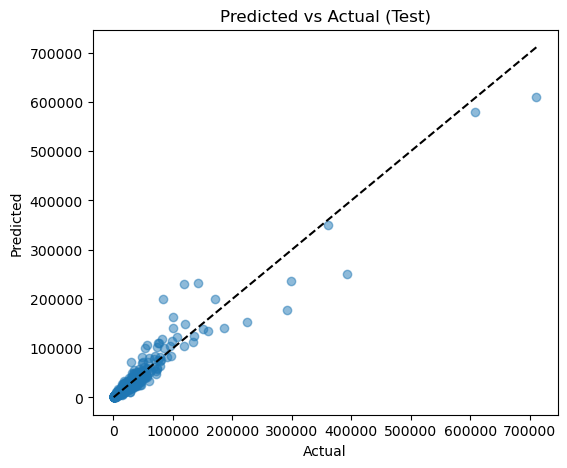

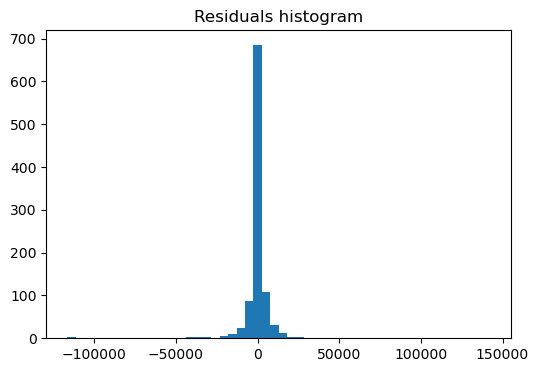

In [34]:
# Cell 10 — fit final model and evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

best_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)  # or pick from CV
final_pipeline = Pipeline([("pre", preprocessor), ("model", best_model)])
final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

# if model_target is log1p, invert preds for original units
def invert_pred(arr):
    if model_target.endswith("_log1p"):
        return np.expm1(arr)
    return arr

y_test_orig = invert_pred(y_test) if isinstance(y_test, (pd.Series, np.ndarray)) else y_test
y_pred_orig = invert_pred(y_pred)

r2 = r2_score(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = mean_squared_error(y_test_orig, y_pred_orig, squared=False)

print("Test R2:", round(r2, 4))
print("Test MAE:", round(mae, 4))
print("Test RMSE:", round(rmse, 4))

# Visuals: Predicted vs Actual
plt.figure(figsize=(6,5))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Test)")
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'k--')
plt.show()

# Residuals
residuals = y_test_orig - y_pred_orig
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50)
plt.title("Residuals histogram")
plt.show()

In [1]:
pip install gradio

  Using cached gradio-5.44.1-py3-none-any.whl.metadata (16 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached Brotli-1.1.0-cp312-cp312-win_amd64.whl.metadata (5.6 kB)
  Using cached fastapi-0.116.1-py3-none-any.whl.metadata (28 kB)
  Using cached ffmpy-0.6.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached gradio_client-1.12.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached orjson-3.11.3-cp312-cp312-win_amd64.whl.metadata (43 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached ruff-0.12.11-py3-none-win_amd64.whl.metadata (26 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached starlette-0.47.3-py3-none-a

In [9]:
import pandas as pd

df = pd.read_csv("hospital dataset.csv")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (4960, 33)
Columns: ['Age Group', 'Count of APR DRG Code', 'APR DRG Description', 'Count of APR MDC Code', 'APR MDC Description', 'APR Medical Surgical Description', 'APR Risk of Mortality', 'Count of APR Severity of Illness Code', 'APR Severity of Illness Description', 'Sum of Birth Weight', 'CCSR Diagnosis Code', 'CCSR Diagnosis Description', 'CCSR Procedure Code', 'CCSR Procedure Description', 'Sum of Discharge Year', 'Emergency Department Indicator', 'Ethnicity', 'Facility Name', 'Gender', 'Hospital County', 'Hospital Service Area', 'Sum of Length of Stay', 'Sum of Operating Certificate Number', 'Patient Disposition', 'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3', 'Count of Permanent Facility Id', 'Race', 'Sum of Total Charges', 'Sum of Total Costs', 'Type of Admission', 'Zip Code - 3 digits']


,Age Group,Count of APR DRG Code,APR DRG Description,Count of APR MDC Code,APR MDC Description,APR Medical Surgical Description,APR Risk of Mortality,Count of APR Severity of Illness Code,APR Severity of Illness Description,Sum of Birth Weight,...,Patient Disposition,Payment Typology 1,Payment Typology 2,Payment Typology 3,Count of Permanent Facility Id,Race,Sum of Total Charges,Sum of Total Costs,Type of Admission,Zip Code - 3 digits
0,0 to 17,1,ABDOMINAL PAIN,1,DISEASES AND DISORDERS OF THE DIGESTIVE SYSTEM,Medical,Minor,1,Moderate,NaN,...,Home or Self Care,Medicaid,Medicaid,NaN,1.0,White,76624.58,11638.06,Emergency,117
1,0 to 17,1,ACUTE ANXIETY & DELIRIUM STATES,1,MENTAL DISEASES AND DISORDERS,Medical,Minor,1,Moderate,NaN,...,Home or Self Care,Medicaid,Medicaid,NaN,1.0,Other Race,10155.49,6749.34,Emergency,100
2,0 to 17,1,ACUTE BRONCHITIS AND RELATED SYMPTOMS,1,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,Medical,Minor,1,Major,NaN,...,Home or Self Care,Private Health Insurance,NaN,NaN,1.0,White,73197.65,33309.64,Emergency,100
3,0 to 17,1,ACUTE KIDNEY INJURY,1,DISEASES AND DISORDERS OF THE KIDNEY AND URINA...,Medical,Major,1,Major,NaN,...,Home or Self Care,Medicaid,Self-Pay,NaN,1.0,Other Race,59651.17,18065.91,Urgent,112
4,0 to 17,1,ADJUSTMENT DISORDERS & NEUROSES EXCEPT DEPRESS...,1,MENTAL DISEASES AND DISORDERS,Medical,Minor,1,Major,NaN,...,Home or Self Care,Medicaid,NaN,NaN,1.0,Black/African American,18200.00,12095.72,Emergency,112


In [11]:
target = "Sum of Total Costs"   # change this to your actual target column!

# Drop target and get features
X = df.drop(columns=[target], errors="ignore")
y = df[target]

# Detect feature types
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Numeric Features:", num_features)
print("Categorical Features:", cat_features)

Numeric Features: ['Count of APR DRG Code', 'Count of APR MDC Code', 'Count of APR Severity of Illness Code', 'Sum of Birth Weight', 'Sum of Discharge Year', 'Sum of Length of Stay', 'Sum of Operating Certificate Number', 'Count of Permanent Facility Id', 'Sum of Total Charges']
Categorical Features: ['Age Group', 'APR DRG Description', 'APR MDC Description', 'APR Medical Surgical Description', 'APR Risk of Mortality', 'APR Severity of Illness Description', 'CCSR Diagnosis Code', 'CCSR Diagnosis Description', 'CCSR Procedure Code', 'CCSR Procedure Description', 'Emergency Department Indicator', 'Ethnicity', 'Facility Name', 'Gender', 'Hospital County', 'Hospital Service Area', 'Patient Disposition', 'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3', 'Race', 'Type of Admission', 'Zip Code - 3 digits']


In [24]:
import pandas as pd
import gradio as gr
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Load dataset
df = pd.read_csv("hospital dataset.csv")

# Target column
target = "Sum of Total Costs"
X = df.drop(columns=[target])
y = df[target]

# Feature types
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

# Preprocessing
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# Model
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train
model.fit(X, y)

# -----------------------
# Gradio function
# -----------------------
def predict_cost(*inputs):
    data = {col: [val] for col, val in zip(num_features + cat_features, inputs)}
    df_input = pd.DataFrame(data)
    pred = model.predict(df_input)[0]
    return f"Predicted Healthcare Cost: {pred:.2f}"

# Inputs (simple version: numbers + textboxes)
inputs = []
for col in num_features:
    inputs.append(gr.Number(label=col))
for col in cat_features:
    inputs.append(gr.Textbox(label=col))

# Interface
interface = gr.Interface(
    fn=predict_cost,
    inputs=inputs,
    outputs="text",
    title="Healthcare Cost Prediction"
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
